In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, precision_score, recall_score,classification_report
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
import warnings
from sklearn.cluster import KMeans

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/final_data.csv")

In [9]:
X = df.drop(['is_churn'],axis=1)
y = df['is_churn']

In [10]:
counter = Counter(y)
print("Original class distribution:", counter)

Original class distribution: Counter({0: 293803, 1: 62474})


In [11]:
df.columns

Index(['city', 'bd', 'gender', 'registered_via', 'is_churn',
       'payment_plan_sum', 'plan_list_price', 'actual_amount_paid',
       'discount_rate', 'is_auto_renew', 'is_cancel', 'transaction_count',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'registration_duration', 'listening_duration'],
      dtype='object')

In [12]:
categorical_features = ["city", "registered_via", "gender", "payment_plan_sum"]

In [13]:
counter = Counter(y)
print("class distribution:", counter)
# SMOTE_NC 적용
smote_nc = SMOTENC(categorical_features=categorical_features, sampling_strategy=0.6, random_state=42)
X_res, y_res = smote_nc.fit_resample(X, y)

# 오버 샘플링 후 클래스 분포 확인
counter = Counter(y_res)
print("Resampled class distribution:", counter)

# 데이터 분할 (훈련/테스트)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 스케일링 (연속형 변수만 적용됨)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_res_scaled = scaler.transform(X_test_res)

class distribution: Counter({0: 293803, 1: 62474})
Resampled class distribution: Counter({0: 293803, 1: 176281})


In [15]:
stratified_kfold = StratifiedKFold(n_splits=5)
rf_clf_over = RandomForestClassifier(max_depth= 62, n_estimators= 100, random_state=42, warm_start=False)

rf_accuracy_over = []
rf_precision_over = []
rf_recall_over = []
rf_matrix_over = []
rf_curve_over = []

for train_index, val_index in stratified_kfold.split(X_res, y_res):
    X_train_1, y_train_1 = X_res.iloc[train_index], y_res.iloc[train_index]
    X_val, y_val = X_res.iloc[val_index], y_res.iloc[val_index]

    rf_clf_over.fit(X_train_1, y_train_1)
    y_pred_rf = rf_clf_over.predict(X_val)
    y_pred_proba = rf_clf_over.predict_proba(X_val)[:, 1]

    rf_accuracy_over.append(accuracy_score(y_val, y_pred_rf))
    rf_precision_over.append(precision_score(y_val, y_pred_rf))
    rf_recall_over.append(recall_score(y_val, y_pred_rf))
    rf_matrix_over.append(confusion_matrix(y_val, y_pred_rf))
    (rf_curve_over.





     append(roc_curve(y_val, y_pred_proba)))

print("RF 정확도:", round(np.mean(rf_accuracy_over),3))
print("RF 정밀도:", round(np.mean(rf_precision_over),3))
print("RF 재현율:", round(np.mean(rf_recall_over),3))

RF 정확도: 0.891
RF 정밀도: 0.865
RF 재현율: 0.842


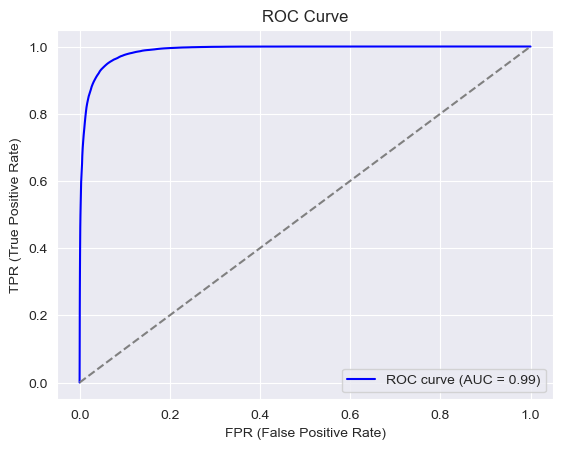

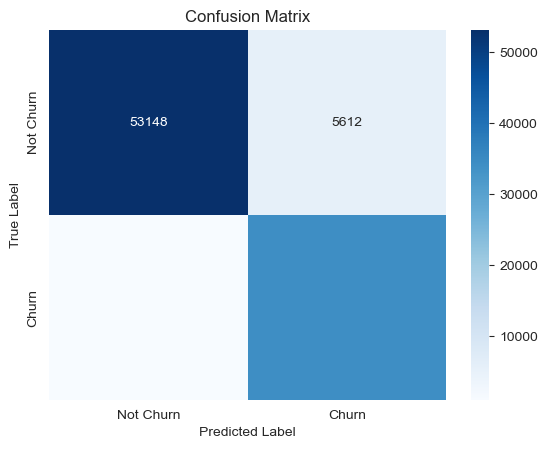

In [16]:
fpr, tpr, thresholds = rf_curve_over[2]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_rf)
cm = rf_matrix_over[4]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()